In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from SubpopulationsLib.DataProcessing import create_SIR_data
from SubpopulationsLib.InfectiousModels import SIR
from SubpopulationsLib.Metrics import MAPE
from SubpopulationsLib.Subpopulations import create_gaussian_dictionary, \
    find_theta_dictionary, find_theta_sa
from SubpopulationsLib.Subpopulations import mixture_exponentials, mixture_SIR

# Set the parameters of this experiment

In [2]:
# Determine the dates to use
start_date = '7/30/20'
end_date = '7/30/21'

# Set the path to the datasets
file_path = './Data/'
lookup_table_path = './Data/UID_ISO_FIPS_LookUp_Table.csv'

# Set the minimum number of observations that should be available for the experiment
min_observ = 5

# Determine the maximum horizon for forecasting (in weeks)
max_k = 4

# Get the name of all available countries in the dataset
dataframe = pd.read_csv(lookup_table_path)

country_names = np.unique(dataframe['Country_Region'].values)
num_countries = len(country_names)

# Set the parameters for the Dictionary approaches

In [3]:
# Create a dictionaty with Gaussians
T = 52
possible_mu = np.arange(0,52,2)
possible_sigma = np.arange(1,30,2)
possible_skewness = np.array([0])

D_Gaussian = create_gaussian_dictionary(
    T, possible_mu, possible_sigma, possible_skewness
)

# Load the dictionary with SIR
D_SIR = pickle.load(open('./D_SIR.pkl', 'rb'))

# Set the parameters for the mixture of signals approach

In [4]:
num_mixtures = 3

# For the Gaussian model
bounds_mu = (0,50)
bounds_sigma = (1,6)
bounds_coef = (0,300000)

bound_list_Gaussian = [bounds_mu, bounds_sigma, bounds_coef]

bounds_Gaussian = list()

for element in bound_list_Gaussian:
    for i in range(num_mixtures):
        bounds_Gaussian.append(element)
        
# For the SIR model
bound_S = (0,1E8)
bound_beta = (0,1)
bound_gamma = (0,1)
bound_coef = (0,1000)
bound_k = (0,50)
bound_list_SIR = [bound_S, bound_beta, bound_gamma, bound_coef, bound_k]

bounds_SIR = list()

for element in bound_list_SIR:
    for i in range(num_mixtures):
        bounds_SIR.append(element)

# Run the experiment for a single country
Set the name of the country and prepare the dictionary for storing the results

In [5]:
country_name = 'Canada'
results_dict = dict()
results_dict[country_name] = dict()

for i in range(4):
    results_dict[country_name]['Week ' + str(i+1)] = dict()

    results_dict[country_name]['Week ' + str(i+1)]['GT'] = list()

    results_dict[country_name]['Week ' + str(i+1)]['Gaussian_dict'] = list()
    results_dict[country_name]['Week ' + str(i+1)]['SIR_dict'] = list()
    results_dict[country_name]['Week ' + str(i+1)]['Gaussian_mix'] = list()
    results_dict[country_name]['Week ' + str(i+1)]['SIR_mix'] = list()

    results_dict[country_name]['Week ' + str(i+1)]['SLOW'] = list()
    results_dict[country_name]['Week ' + str(i+1)]['SIR'] = list()

In [6]:
print(country_name)

# Transform the data into SIR format
S, I, R = create_SIR_data(country_name, file_path, lookup_table_path, start_date, end_date)

indexes_weekly = np.arange(0,S.shape[0],7)

S = S[indexes_weekly]
I = I[indexes_weekly]
R = R[indexes_weekly]

data = I[1:]
# ------------------------------------

for i in range(min_observ, data.shape[0]-max_k):
    print('Analyzing data up to the observation ' + str(i), end='\r')
    # -----------------------------------
    # Classical SIR model
    # -----------------------------------
    sir = SIR()
    sir.train(S[0:i], I[0:i], R[0:i])

    # -------- Dictionary --------------------
    # Get the current observations
    c_data = np.array(data[0:i])
    bias = np.min(c_data)
    norm_I = c_data - bias

    # Using the dicionary, find the parameters theta that best explain
    # the data
    c_D_Gaussian = D_Gaussian[:,0:i]
    c_D_SIR = D_SIR[:,0:i]

    # Fit with Gaussians and SIR's with dictionaries
    theta_Gaussian = find_theta_dictionary(c_D_Gaussian, norm_I, lambda_reg = 1E-3)
    theta_SIR = find_theta_dictionary(c_D_SIR, norm_I, lambda_reg = 1E-3)

    # ----------- Mixture of models -----------
    # ---------------------------------
    # Set the parameters for the mixture of signals approach
    # ---------------------------------
    num_mixtures = 3

    # For the Gaussian model
    bounds_mu = (0,i+6)
    bounds_sigma = (1,6)
    bounds_coef = (0,300000)

    bound_list_Gaussian = [bounds_mu, bounds_sigma, bounds_coef]

    bounds_Gaussian = list()

    for element in bound_list_Gaussian:
        for j in range(num_mixtures):
            bounds_Gaussian.append(element)

    # For the SIR model
    bound_S = (0,1E8)
    bound_beta = (0,1)
    bound_gamma = (0,1)
    bound_coef = (0,1000)
    bound_k = (0,i+6)
    bound_list_SIR = [bound_S, bound_beta, bound_gamma, bound_coef, bound_k]

    bounds_SIR = list()

    for element in bound_list_SIR:
        for j in range(num_mixtures):
            bounds_SIR.append(element)

    # Fit with mixtuers of models
    params_gaussian = find_theta_sa(bounds_Gaussian, norm_I, mixture_exponentials)
    params_SIR = find_theta_sa(bounds_SIR, norm_I, mixture_SIR)

    # -----------------------------------------
    # Make the predictions in advance
    S_last = S[i-1]
    I_last = I[i-1]
    R_last = R[i-1]

    for k in range(1, max_k + 1):
        x_hat_Gaussian_Dict = np.matmul(D_Gaussian[:, i-1 + k].T, theta_Gaussian) + bias
        x_hat_SIR_Dict = np.matmul(D_SIR[:, i-1 + k].T, theta_SIR) + bias

        c_T = len(c_data)
        y_hat_Gaussian_Mix = mixture_exponentials(params_gaussian, c_T + k) + bias
        y_hat_SIR_Mix = mixture_SIR(params_SIR, c_T + k) + bias

        S_last, I_last, R_last = sir.predict_next(S_last, I_last, R_last)

        results_dict[country_name]['Week ' + str(k)]['GT'].append(data[i-1 + k])

        results_dict[country_name]['Week ' + str(k)]['Gaussian_dict'].append(x_hat_Gaussian_Dict)
        results_dict[country_name]['Week ' + str(k)]['SIR_dict'].append(x_hat_SIR_Dict)
        results_dict[country_name]['Week ' + str(k)]['Gaussian_mix'].append(y_hat_Gaussian_Mix[-1])
        results_dict[country_name]['Week ' + str(k)]['SIR_mix'].append(y_hat_SIR_Mix[-1])

        results_dict[country_name]['Week ' + str(k)]['SLOW'].append(c_data[-1])

        results_dict[country_name]['Week ' + str(k)]['SIR'].append(I_last)

Canada


/home/rvega/SubpopulationModels/SubpopulationsLib/InfectiousModels.py:352: RuntimeWarning: invalid value encountered in double_scalars
  change_S = beta*I*S / P + imported
/home/rvega/SubpopulationModels/SubpopulationsLib/InfectiousModels.py:352: RuntimeWarning: overflow encountered in double_scalars
  change_S = beta*I*S / P + imported
/home/rvega/SubpopulationModels/SubpopulationsLib/InfectiousModels.py:353: RuntimeWarning: invalid value encountered in double_scalars
  change_R = gamma * I


/home/rvega/SubpopulationModels/SubpopulationsLib/InfectiousModels.py:357: RuntimeWarning: invalid value encountered in double_scalars
  I_next = I + change_S - change_R


# Visualize the results

Prediction 1 weeks ahead
MAPE Gaussian Dict
(2.7853559279012314, 2.1033901681327913)
MAPE SIR Dict
(3.19702699463312, 2.2652701317740678)
MAPE Gaussian Mix
(5.121431464626491, 9.39412893509846)
MAPE SIR Mix
(6.165933233603696, 5.818979507793809)
MAPE SLOW
(4.144099889382514, 3.024091930033702)
MAPE SIR
(7.831475892730436, 6.0251688171462385)


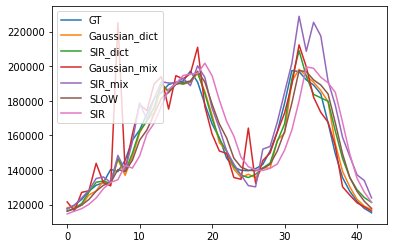

Prediction 2 weeks ahead
MAPE Gaussian Dict
(5.803080054021006, 4.563067261539686)
MAPE SIR Dict
(5.7332443145891485, 3.9281158595630794)
MAPE Gaussian Mix
(16.679252532172477, 42.31224567619239)
MAPE SIR Mix
(11.256654874018695, 10.124750356142767)
MAPE SLOW
(8.118407447634429, 5.63686539326474)
MAPE SIR
(11.827114568314503, 8.794446729457075)


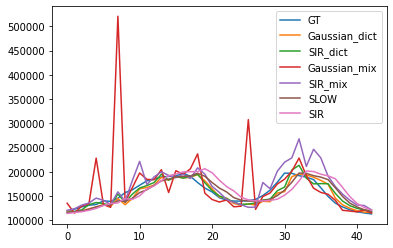

Prediction 3 weeks ahead
MAPE Gaussian Dict
(9.411598855921556, 6.453401328570247)
MAPE SIR Dict
(8.081875333984566, 5.661833238160796)
MAPE Gaussian Mix
(29.500522881844613, 67.20686745204003)
MAPE SIR Mix
(19.497726302923496, 18.6278711821076)
MAPE SLOW
(12.000948999240308, 7.953015122174472)
MAPE SIR
(15.945098181907058, 11.516539562755153)


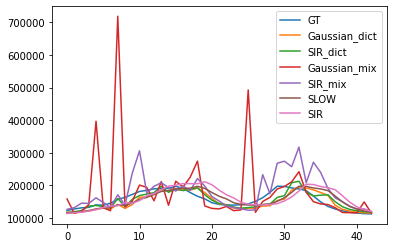

Prediction 4 weeks ahead
MAPE Gaussian Dict
(12.674566622372632, 8.24891875280158)
MAPE SIR Dict
(10.381408661277668, 7.462309763680513)
MAPE Gaussian Mix
(29.927369434789096, 45.98829446539793)
MAPE SIR Mix
(33.13806661245534, 36.24345042817961)
MAPE SLOW
(15.764720639866857, 9.999475165365947)
MAPE SIR
(19.996836756384624, 14.235404318312288)


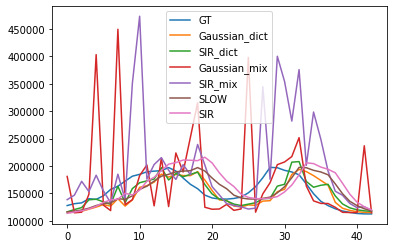

In [8]:
for k in range(1, max_k+1):
    print('Prediction ' + str(k) + ' weeks ahead')
    gt = np.array(results_dict[country_name]['Week ' + str(k)]['GT'])

    predictions_Gaussian_Dict = np.array(results_dict[country_name]['Week ' + str(k)]['Gaussian_dict'])
    predictions_SIR_Dict = np.array(results_dict[country_name]['Week ' + str(k)]['SIR_dict'])
    predictions_Gaussian_Mix = np.array(results_dict[country_name]['Week ' + str(k)]['Gaussian_mix'])
    predictions_SIR_Mix = np.array(results_dict[country_name]['Week ' + str(k)]['SIR_mix'])

    slow = np.array(results_dict[country_name]['Week ' + str(k)]['SLOW'])
    SIR = np.array(results_dict[country_name]['Week ' + str(k)]['SIR'])

    print('MAPE Gaussian Dict')
    print(MAPE(gt, predictions_Gaussian_Dict))
    print('MAPE SIR Dict')
    print(MAPE(gt, predictions_SIR_Dict))
    print('MAPE Gaussian Mix')
    print(MAPE(gt, predictions_Gaussian_Mix))
    print('MAPE SIR Mix')
    print(MAPE(gt, predictions_SIR_Mix))
    print('MAPE SLOW')
    print(MAPE(gt, slow))
    print('MAPE SIR')
    print(MAPE(gt, SIR))


    plt.figure()
    plt.plot(gt)
    plt.plot(predictions_Gaussian_Dict)
    plt.plot(predictions_SIR_Dict)
    plt.plot(predictions_Gaussian_Mix)
    plt.plot(predictions_SIR_Mix)
    plt.plot(slow)
    plt.plot(SIR)
    plt.legend(['GT', 'Gaussian_dict','SIR_dict', 'Gaussian_mix', 'SIR_mix','SLOW', 'SIR'])
    plt.show()